# Simulating the 1945 Makran Tsunami using Thetis

The 1945 Makran Tsunami was a large tsunami which originated due to the 1945 Balochistan earthquake. The resulting tsunami is beielved to have killed around 4000 people along the coast of modern day Pakistan, India, Iran and Oman. Tidal records indicate that the tsunami was recorded as far as the islands of Seychells and Minicoy. Moden simulations of the tsunami indicate tsunami elevations would have been observed across the islands of the Maldives as well. 

Here we will model the tsunami using elevations from actual fault estimations.

<img src="figures/Map Of Region.png" style="height:1000px, width:1000px">

As usual we begin by importing the required python libraries and modules. 

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import scipy.interpolate  # used for interpolation
import pyproj  # used for coordinate transformations
import math
from thetis import *

### Importing the mesh
Next we will import the mesh (this mesh was actually created using [qmesh](http://qmesh.org) mentioned in yesterday's lecture). Additionally we will visualise the mesh as well using the firedrake plot utility function. The plot function provides an easy way to plot of firedrake functions.    

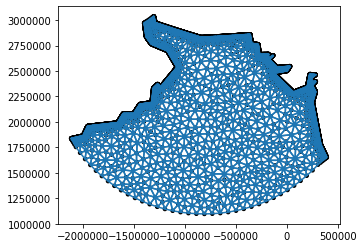

In [2]:
mesh = Mesh('runfiles/mesh.msh')
plot(mesh);

The mesh is created using a [UTM-based coordinate system](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system), which divides the world in different zones. In each zone coordinates can be accurately represented by a flat x,y plane. The zone that covers our region is UTM zone 43 which is valid between 72 and 78 degrees longitude East.

### Setup the bathymetry

Next we will define a bathymetry function. For the purpose of this simulation to keeps things simple we will assign a constant depth of 20m. Before creating the bathymetry function and assigning depth we will visualise the bathymetry of the area using the GEBCO bathymetry dataset.              

<img src="figures/Depth.png" style="height:1000px, width:1000px">

To start of with however, we will simply use a constant depth of 2000m. The bathymetry function will be defined within the function space of piecewise linear functions ("CG" for Continous Galerkin and a polynomial degree of 1). We will again visualise the depth to confirm if the value is assigned across the domain.

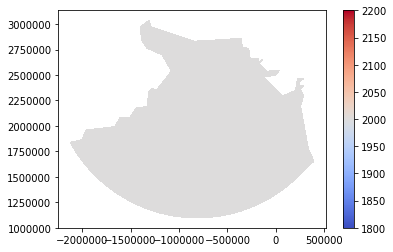

In [3]:
P1 = FunctionSpace(mesh, "CG", 1)
bathymetry_2d = Function(P1, name='Bathymetry')
depth = 2000.0
bathymetry_2d.assign(depth)

plot(bathymetry_2d);

### Initial Elevation

Now we will define a function for the initial elevation, using the same `P1` function space. This initial elevation function will set the values for the initial elevation in our simulation. It contains a perturbation in the North of the domain that represent the initial stage of a tsunami.

In [4]:
init_elev = Function(P1, name = 'init_elev')

After defining the initial elevation function we need to set the values of the function, across our mesh. The initial elevation is given to us stored on a regular lon, lat grid. In our simulation we will be using a mesh defined in UTM zone 43 coordinates, and thus we need to perform a coordinate transformation and interpolate between the two grids.

First we extract the coordinates of the mesh (in UTM zone 43) and the values of the initial value function as numpy arrays:

In [5]:
mesh_coordinates = mesh.coordinates.dat.data
init_elev_data = init_elev.dat.data

Next we will import the data that we wish to be interpolate onto the initial elevation function. Here the data that we wish to be interpolated on to our elevation function is the vertical displacement of the free-surface due to the earthquake. Given the earthquake fault parameters which are available from various sources such as USGS these deformations can be obtained through various means. Here we will use the output obtained from an 'Okada model' utilising single-fault parameters as provided in Arjun.et.al. We also print the first row of the data, the columns are arranged as Longitude, Latitude, x, y and z displacement.

In [6]:
data = np.genfromtxt('runfiles/outputs.txt')
print (np.round(data[0],5))

[6.000e+01 1.500e+01 2.930e-03 1.914e-02 3.260e-03]


In order to interpolate the data values onto our mesh, we will use a nearest-neighbour interpolator from scipy. We extract the first two columns (lon and lat) as the coordinates, and the fourth column (vertical displacement) as the values we want to interpolate:

In [7]:
intp = scipy.interpolate.NearestNDInterpolator(data[:,0:2], data[:,4])

`intp` is now an interpolator object that can interpolate the data at any location using `intp(lon, lat)`. However since our mesh is in Universal Transverse Mercator coordinate system (UTM) coordinates, we first convert the coordinates of the mesh points into lat, lon. This is done using the [pyproj](https://pyproj4.github.io/pyproj/stable/) library:

In [8]:
outproj = pyproj.Proj(init='epsg:4326')
inproj = pyproj.Proj(init='epsg:32643') 
lon, lat = pyproj.transform(inproj, outproj, mesh_coordinates[:,0], mesh_coordinates[:,1])

`lon` and `lat` are now two numpy arrays with longitude and latitude of all mesh points. These can be fed straight into `intp` to return an array of the interpolated values in these points. By assigning it to the `init_elev_data` array these will become the values of the `init_elev` function.

In [9]:
init_elev_data[:] = intp(lon, lat)

Let's plot this to check:

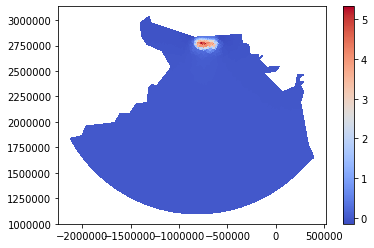

In [10]:
plot(init_elev);

### Setting Solver Options
Now we have everything we need to setup the solver and set its options. The setup is very similar to what was discussed for the 2D channel example.

In [11]:
solver_obj = solver2d.FlowSolver2d(mesh, bathymetry_2d)
options = solver_obj.options
# total duration in seconds
options.simulation_export_time = 900.0 
# export interval in seconds
options.simulation_end_time = 3600.0 * 2
options.timestepper_type = 'CrankNicolson'
options.timestep = 5.0
options.output_directory = 'outputs_makran_tsunami'
options.fields_to_export = []
options.fields_to_export_hdf5 = ['elev_2d', 'uv_2d']

### Boundary and Initial Conditions
Next we define the boundary conditions of our model. We will set the velocities at the coastlines and open boundaries to zero. At the open boundaries we set both the normal velocity and elevation to zero, this leads to weakly reflective boundaries.

In [12]:
solver_obj.bnd_functions['shallow_water'] = {
        100: {'un': 0.0},
        200: {'un': 0.0, 'elev' :0.0}
    }

Additionaly we set the initial conditions for our simulation. Here we use the `init_elev` we set up above. Initial velocities are zero (by default):

In [13]:
solver_obj.assign_initial_conditions(elev=init_elev)

dt = 5.0
Using time integrator: CrankNicolson


Now set the solver iterator to start the simulation running. Note that since we do not have any time varying forcing, we do not need a `update_forcings` function.

In [14]:
solver_obj.iterate()

    0     0 T=      0.00 eta norm: 477519.7838 u norm:     0.0000  0.00
    1   180 T=    900.00 eta norm: 261265.7773 u norm: 25396.9495 156.41
    2   360 T=   1800.00 eta norm: 288047.1541 u norm: 21171.9421 179.42
    3   540 T=   2700.00 eta norm: 294684.3989 u norm: 18837.3311 168.94
    4   720 T=   3600.00 eta norm: 256980.6728 u norm: 20564.1581 179.59
    5   900 T=   4500.00 eta norm: 281777.9836 u norm: 18151.1857 174.37
    6  1080 T=   5400.00 eta norm: 268474.9461 u norm: 17317.1590 169.68
    7  1260 T=   6300.00 eta norm: 224371.0474 u norm: 19226.2677 157.73
    8  1440 T=   7200.00 eta norm: 256650.3876 u norm: 16484.0618 158.67


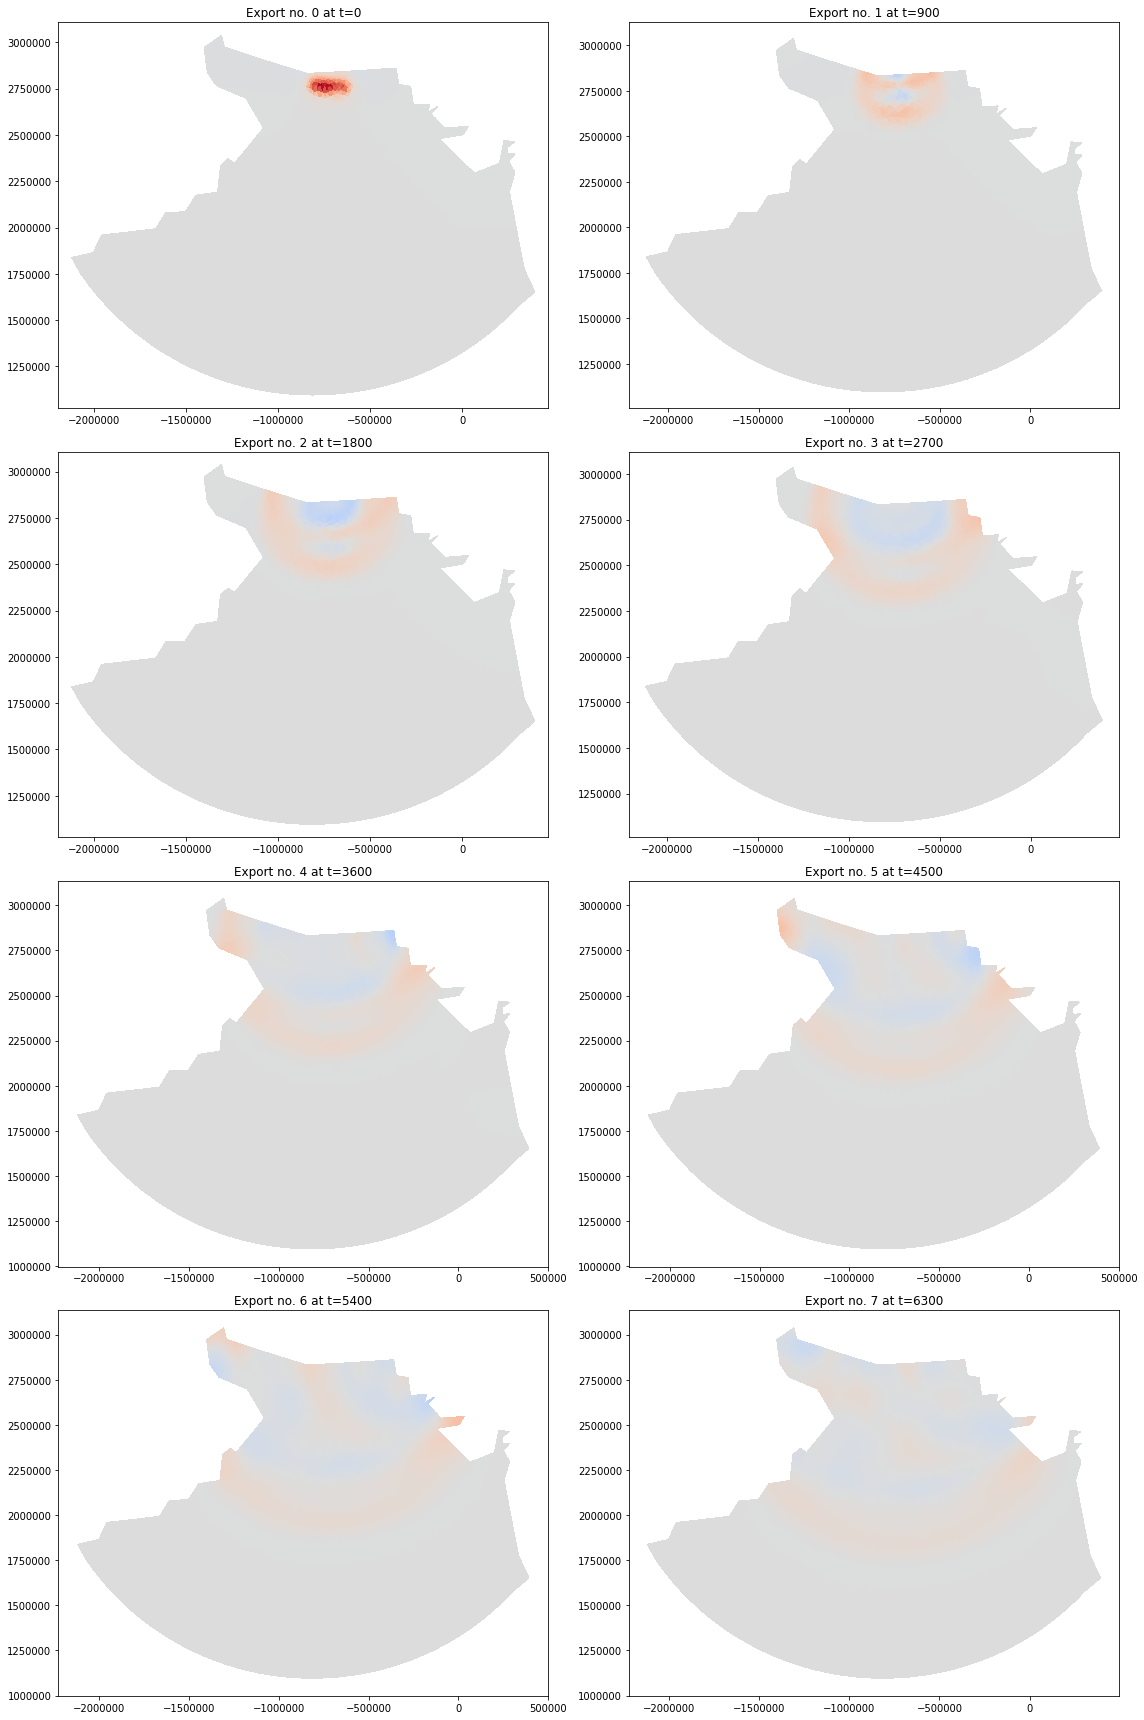

In [28]:
elev = Function(solver_obj.function_spaces.H_2d, name='elev_2d')
uv = Function(solver_obj.function_spaces.U_2d, name='uv_2d')

last_idx = solver_obj.i_export
nrows = math.ceil(last_idx/2)
fig, axes  = plt.subplots(nrows, 2, figsize=(16, 6*nrows))

for idx, ax in enumerate(axes.flatten()):
    filename =  os.path.join(options.output_directory, 'hdf5','Elevation2d_%05d' % idx)
    dc = DumbCheckpoint(filename, mode=FILE_READ)
    dc.load(elev)
    dc.close()
    # by specifying cmap=None above, we avoid displaying a colorbar
    plot(elev, axes=ax, cmap=None)
    # Firedrake sets an automatic colorbar range which therefore changes per timestep
    # instead, we want to fix it:
    cbar = ax.collections[-1].set_clim(-5, 5)
    # we do want to set an appropriate colormap
    cbar = ax.collections[-1].set_cmap(matplotlib.cm.coolwarm)
    ax.axis('equal')
    ax.title.set_text('Export no. %d at t=%.0f' % (idx, options.simulation_export_time*idx))
    plt.tight_layout()

## Further Practice

a. Instead of the constant bathymetry, load the bathymetry file provided in the runfiles folder, visuallize the bathymetry and use this bathymetry to run the model. Notice any difference?

Hint, to load the bathymetry, use:

In [54]:
dc = DumbCheckpoint('runfiles/bathy', mode=FILE_READ)
dc.load(bathymetry_2d, name='bathy');

b. Manipulate the boundary conditions and note the difference. For example change the open boundary to only prescribed a zero normal velocity.